# Pylops - timeshift estimation

### Author: M.Ravasi

This notebook aims at showing how we can take advantage of PyLops operators while solving nonlinear inverse problems with interfaces (i.e., solver) provided by SciPy.

We consider a classic problem in signal processing: registration of two signals. 
Here one signal (called monitor) is a shifted version of another (called baseline), and the shift is allowed to be non-stationary.

Use cases of this application are registration of speech recording as well as time-lapse seismic data. The first is inherently a 1d problem, while the latter is a 2d/3d extension of the former.

So far we experiment with different solvers and show how to use them for solving this problem. No attention is placed on the performance of our implementation (i.e., some operations required to evaluate the Jacobian/gradient are also required to evaluate the functional and should not be repeated), however in future this problem can be solved by defining a nonlinear operator as a object with the following methods:

- func
- jac
- grad 
(- hess)

as well as a member variable storing the latest func evaluation, such that when invoking jac the func is not called again...

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

import pylops

from scipy.sparse.linalg import aslinearoperator
from scipy.optimize import minimize, approx_fprime, check_grad, least_squares
from scipy.ndimage.filters import gaussian_filter
from scipy.signal.windows import hamming

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.avo.poststack              import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import IRLS as IRLSpylops
from pylops.optimization.sparsity      import FISTA

## 1D Modelling

Data equation: $ m(t) = b(t-\delta t)$

If $\delta t > 0$, the monitor is delayed with respect to the baseline, it means there is a velocity slowdown ($\delta v < 0$).

If $\delta t < 0$, the monitor is anticipated with respect to the baseline, it means there is a velocity speedup ($\delta v >0$).

When we create the monitor synthetically, we need to apply the opposite of the shift we expect to recover.



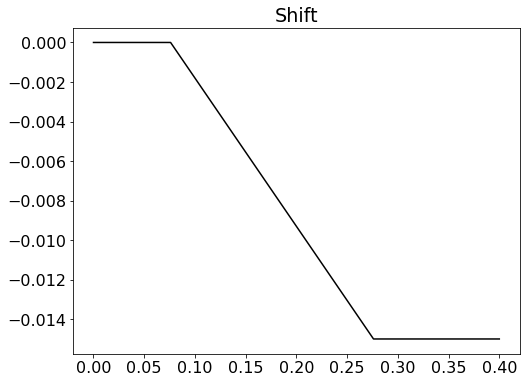

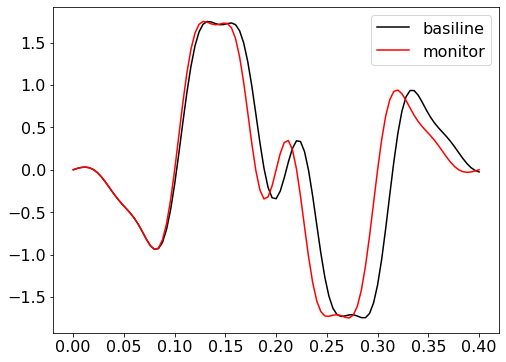

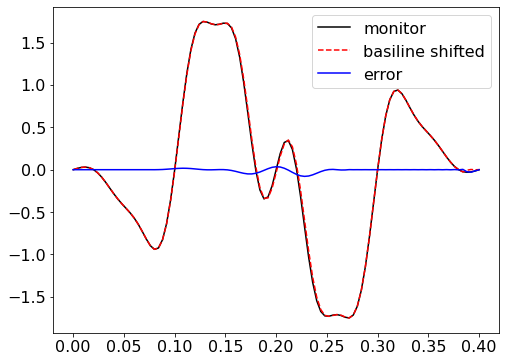

In [2]:
dt = 0.004
nt = 101
t = np.arange(nt)*dt

m = np.sin(2*np.pi*10*t)
m = np.sin(2*np.pi*10*t) + 0.4*np.sin(2*np.pi*20*t) - 2*np.sin(2*np.pi*5*t)
m = m * hamming(nt)

# apply shift to baseline
strain = np.zeros(nt)
strain[20:70] = -3e-4
shift = np.cumsum(strain)
tshift = t - (-shift)
iava = tshift/dt
SI1op, iava = Interp(nt, iava, kind='sinc', dtype='float64')
b = SI1op * m

plt.figure()
plt.plot(t, shift, 'k')
plt.title('Shift')

plt.figure()
plt.plot(t, b, 'k', label='basiline')
plt.plot(t, m, 'r', label='monitor')
plt.legend()

# apply opposite shift to monitor to recover baseline
tshift = t - shift
iava = tshift/dt
SI1op, iava = Interp(nt, iava, kind='sinc', dtype='float64')
bshifted  = SI1op*b

plt.figure()
plt.plot(t, m, 'k', label='monitor')
plt.plot(t, bshifted, '--r', label='basiline shifted')
plt.plot(t, m - bshifted, 'b', label='error')
plt.legend();

## 1D Inversion

Cost function: $ J(\Delta t) = ||m(t) - b(t- \delta t)||^2 $

Linearization of $b$ at each iteration around new estimate $\delta t_{i+1} = \delta t_i + \Delta t$: $ b(t - (\delta t_i + \Delta t)) = b(t - \delta t_i) - \frac{db}{dt}|_{t=t-\delta t_i} \Delta t  = b(t - \delta t_i) + \mathbf{J_b}\Delta t$ 

Jabobian: $\mathbf{J_b}= -diag\{\frac{db}{dt}|_{t=t-\delta t_i}\}$

Gradient: $\frac{dJ_b}{d\mathbf{\delta t}} = -2 \mathbf{J_b}^T ( m(t) - b(t- \delta t))$

### Single iteration

We start considering the case of solving the inverse problem around its starting guess ($\delta t_0$). This is simply done solving the linearized equation. 

As the function $J$ is a nonlinear with respect to $\delta t$ we should however not expect to reach the global minimum, rather only the mimimum of the linearized quadratic functional.

We can also a second derivative regularization such that the problem that we solve is:

$$
J(\Delta t) = ||m(t) - (b(t- \delta t_0) + \mathbf{J_b}\Delta t)||^2 + \epsilon^2 ||\mathbf{D}_2 (\delta t_0 + \Delta_t)||^2 $
$$

or equivalently:

$$
\begin{bmatrix}
m(t) - b(t- \delta t_0) \\
- \epsilon \mathbf{D}_2 \delta t_0
\end{bmatrix} = 
\begin{bmatrix}
\mathbf{J_b} \\
\epsilon \mathbf{D}_2
\end{bmatrix}
\Delta t
$$
and the final solution is $\delta t = \delta t_0 + \Delta t$

Note that if our starting guess is zero the problem reconducts to:

$$
\begin{bmatrix}
m(t) - b(t) \\
0
\end{bmatrix} = 
\begin{bmatrix}
\mathbf{J_b} \\
\epsilon \mathbf{D}_2
\end{bmatrix}
\Delta t
$$

and $\delta t = \Delta t$

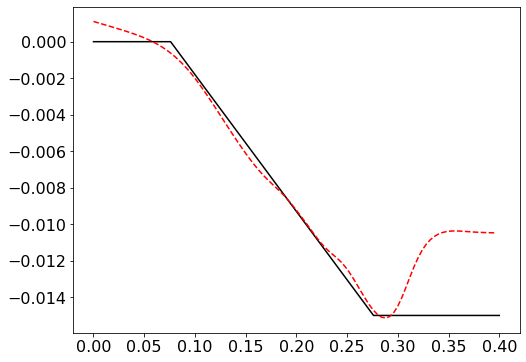

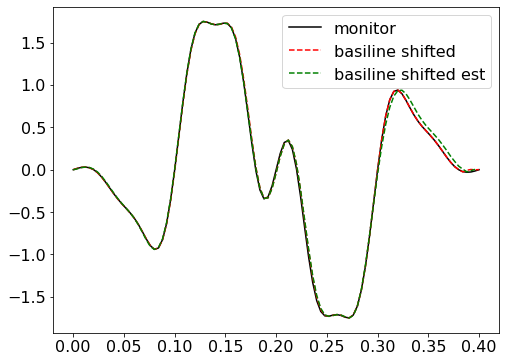

In [3]:
# Data
mbdiff = m[0:-1] - b[0:-1]

# Jabobian
Dm = - Diagonal((b[1:] - b[0:-1]) / dt)
    
# Second Derivative regularization
R = SecondDerivative(nt-1)
shift_est = regularized_inversion(Dm, mbdiff, [R, ], epsRs=[1e3, ], **dict(iter_lim=200))[0]

# shift back
tshift = t[:-1] - shift_est
iava = tshift / dt
SI1op, iava = Interp(nt, iava, kind='sinc', dtype='float64')
bshifted_est  = SI1op * b

plt.figure()
plt.plot(t, shift, 'k')
plt.plot(t[:-1], shift_est, '--r')

plt.figure()
plt.plot(t, m, 'k', label='monitor')
plt.plot(t, bshifted, '--r', label='basiline shifted')
plt.plot(t[:-1], bshifted_est, '--g', label='basiline shifted est')
plt.legend();

### Gauss-newton inversion

Gauss-Newton: $\delta t_{i+1} =  \delta t_i + \mathbf{J_b}^{-1} (m(t) - b(t - \delta t_i)) \quad i=0,N_{iter}$ 

Note that since we are now required to compute the Jacobian at the current estimate of the shift ($\delta t_i$), we will use sinc interpolation to resample the input signal at $t-\delta t_i$ and at $t-\delta t_i + dt$ and the compute the first-order forward derivatives.

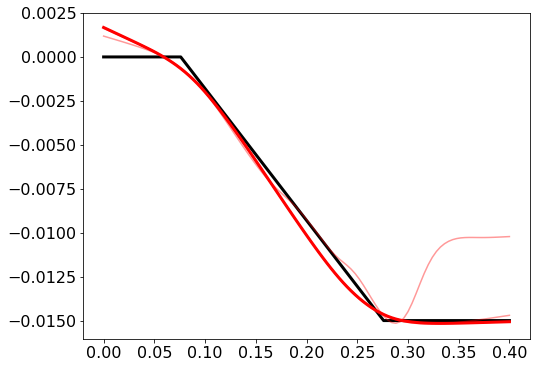

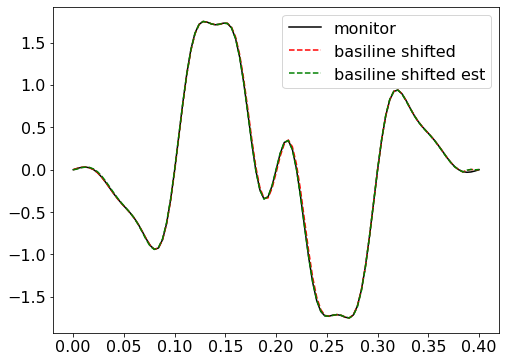

In [4]:
niter = 5

shift_est = np.zeros(nt)
shift_ests = np.zeros((niter, nt))

for iiter in range(niter):
    # Interpolate baseline to current time shift estimate
    iava = (t - shift_est)/dt
    SIop, _ = Interp(nt, iava, kind='sinc', dtype='float64')
    SI1op, _ = Interp(nt, iava+1, kind='sinc', dtype='float64')
    bshift = SIop * b
    b1shift = SI1op * b
    
    # Data
    mbdiff = m - bshift
    
    # Jabobian
    Dm = - Diagonal((b1shift - bshift) / dt)
    
    # Second Derivative regularization
    R = SecondDerivative(nt)
    shift_est += regularized_inversion(Dm, mbdiff, [R, ], epsRs=[1e3, ], dataregs=[-R * shift_est, ], 
                                       **dict(iter_lim=200, damp=1e-4))[0]
    shift_ests[iiter] = shift_est

# shift back
tshift = t - shift_est
iava = tshift / dt
SI1op, iava = Interp(nt, iava, kind='sinc', dtype='float64')
bshifted_est  = SI1op * b

plt.figure()
plt.plot(t, shift, 'k', lw=3)
plt.plot(t, shift_est, 'r', lw=3)
plt.plot(t, shift_ests.T, 'r', alpha=0.4)

plt.figure()
plt.plot(t, m, 'k', label='monitor')
plt.plot(t, bshifted, '--r', label='basiline shifted')
plt.plot(t, bshifted_est, '--g', label='basiline shifted est')
plt.legend();

Now we use scipy's ``least_squares`` that implements a stable modification of the basic Gauss-Netwon method called Levenberg-Marquardt

In [5]:
def fun(x, m, b, t, dt, eps):
    nt = len(t)
    iava = (t - x)/dt
    SIop, iava = Interp(nt, iava, kind='sinc', dtype='float64')
    Rop = SecondDerivative(nt)

    bshift = SIop * b
    res = m - bshift
    resr = Rop * x
    return np.hstack((res, eps * resr))

def jacobian(x, m, b, t, dt, esp):
    nt = len(t)
    iava = (t - x)/dt
    SIop, _ = Interp(nt, iava, kind='sinc', dtype='float64')
    SI1op, _ = Interp(nt, iava+1, kind='sinc', dtype='float64')
    J = np.diag((SI1op * b - SIop * b) / dt)
    R = SecondDerivative(nt).todense()
    JR = np.vstack((J, eps * R))
    #return aslinearoperator(JR)
    return JR

`ftol` termination condition is satisfied.
Function evaluations 16, initial cost 9.5974e+00, final cost 5.2302e-03, first-order optimality 9.80e-04.


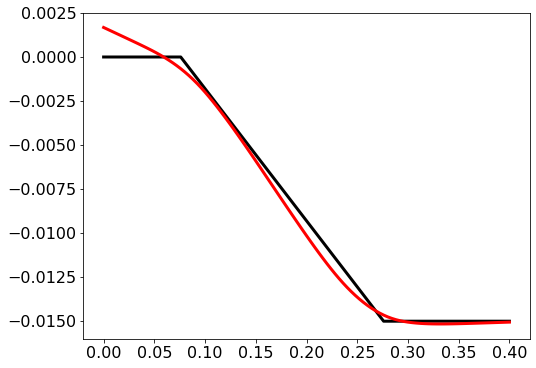

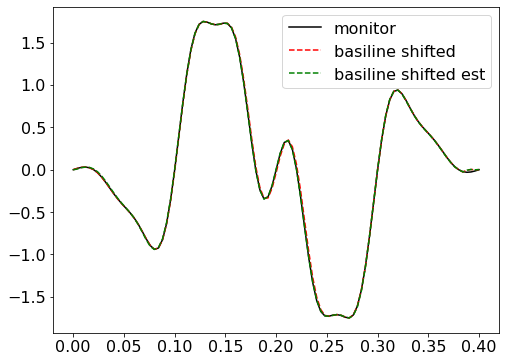

In [6]:
eps = 1e3
f = lambda x: fun(x, m, b, t, dt, eps)
J = lambda x: jacobian(x, m, b, t, dt, eps)

#nlest = least_squares(f, np.zeros(nt), jac=J, method = 'lm', verbose=1)
nlest = least_squares(fun, np.zeros(nt), jac=jacobian, method = 'lm', verbose=1, max_nfev=100, 
                      args=(m, b, t, dt, eps))
shift_est = nlest.x

# shift back
tshift = t - shift_est
iava = tshift/dt
SI1op, iava = Interp(nt, iava, kind='sinc', dtype='float64')
bshifted_est  = SI1op*b

plt.figure()
plt.plot(t, shift, 'k', lw=3)
plt.plot(t, shift_est, 'r', lw=3)

plt.figure()
plt.plot(t, m, 'k', label='monitor')
plt.plot(t, bshifted, '--r', label='basiline shifted')
plt.plot(t, bshifted_est, '--g', label='basiline shifted est')
plt.legend();

In [7]:
def jacobian1(x, m, b, t, dt, esp):
    # with linear operator
    nt = len(t)
    iava = (t - x)/dt
    SIop, _ = Interp(nt, iava, kind='sinc', dtype='float64')
    SI1op, _ = Interp(nt, iava+1, kind='sinc', dtype='float64')
    J = (SI1op * b - SIop * b) / dt
    R = SecondDerivative(nt, dtype=np.float64)
    JR = VStack([Diagonal(J, dtype=np.float64), eps * R])
    return JR

In [8]:
J1 = lambda x: jacobian1(x, m, b, t, dt, eps)

In [9]:
np.allclose(J(np.ones(nt)) @ np.ones(nt), J1(np.ones(nt)) @ np.ones(nt))

True

In [10]:
np.allclose(J(np.ones(nt)).T @ np.ones(2*nt), J1(np.ones(nt)).H @ np.ones(2*nt))

True

`xtol` termination condition is satisfied.
Function evaluations 24, initial cost 9.5974e+00, final cost 8.9546e-04, first-order optimality 4.75e-03.


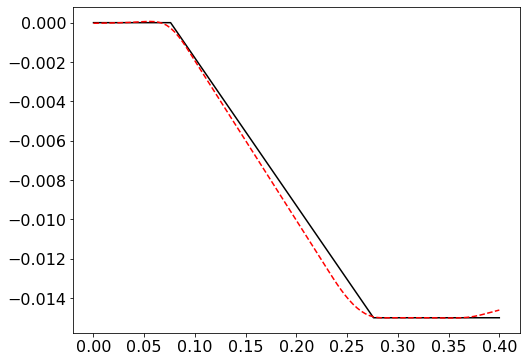

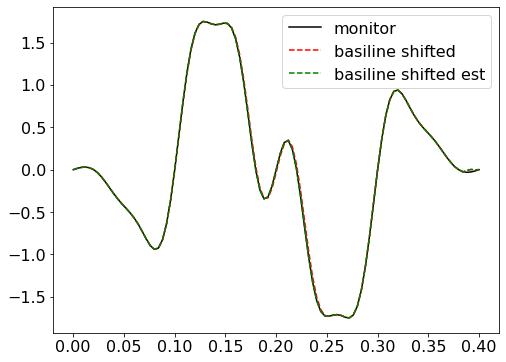

In [11]:
eps = 8e1
nlest = least_squares(fun, np.zeros(nt), jac=jacobian1, method='trf', verbose=1, args=(m, b, t, dt, eps))
shift_est = nlest.x

# shift back
tshift = t - shift_est
iava = tshift/dt
SI1op, iava = Interp(nt, iava, kind='sinc', dtype='float64')
bshifted_est  = SI1op*b

plt.figure()
plt.plot(t, shift, 'k')
plt.plot(t, shift_est, '--r')

plt.figure()
plt.plot(t, m, 'k', label='monitor')
plt.plot(t, bshifted, '--r', label='basiline shifted')
plt.plot(t, bshifted_est, '--g', label='basiline shifted est')
plt.legend();

### Quasi-newton inversion

Let's firt quickly see how scipy check_grad works. We will do it on the following cost function:

$$
J = ||\mathbf{y} - \mathbf{Ax}||^2 
$$

where we know that $\mathbf{g}=-2*\mathbf{\mathbf{A}^H (y - \mathbf{Ax})}$

In [12]:
def fun(x, d, nt, eps):
    Aop = SecondDerivative(nt)
    res = d - Aop * x
    return eps*np.linalg.norm(res)**2

def grad(x, d, nt, eps):
    Aop = SecondDerivative(nt)
    res = d - Aop * x
    return -2*eps*Aop.H * res

1.171877160145235e-06


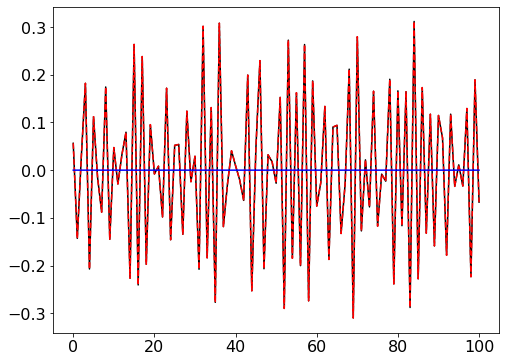

In [13]:
f = lambda x: fun(x, np.ones(nt), nt, 1e-2)
g = lambda x: grad(x, np.ones(nt), nt, 1e-2)

x0 = np.random.normal(0, 1, nt)
gana = g(x0)
gapprox = approx_fprime(x0, f, 1e-8)
print(check_grad(f, g, x0, epsilon=1e-8))

plt.figure()
plt.plot(gana, 'k')
plt.plot(gapprox, '--r')
plt.plot(gana - gapprox , 'b');

We do the same using our cost function and its gradient. 

**NOTE:** gradient test gives poor results, need to investigate why

In [14]:
def fun(x, m, b, t, dt, eps):
    nt = len(t)
    iava = (t - x)/dt
    SIop, iava = Interp(nt, iava, kind='sinc', dtype='float64')
    Rop = SecondDerivative(nt)

    bshift = SIop * b
    res = m - bshift
    return np.linalg.norm(res) ** 2 + eps*np.linalg.norm(Rop * x) ** 2

def grad(x, m, b, t, dt, eps):
    nt = len(t)
    iava = (t - x)/dt
    SIop, _ = Interp(nt, iava, kind='sinc', dtype='float64')
    SI1op, _ = Interp(nt, iava+1, kind='sinc', dtype='float64')
    J = Diagonal((SI1op * b - SIop * b) / dt)
    Rop = SecondDerivative(nt)

    bshift = SIop * b
    res = m - bshift
    grad = 2*J.H*res + 2*eps*Rop.H*Rop*x
    return grad

184.48363260295338


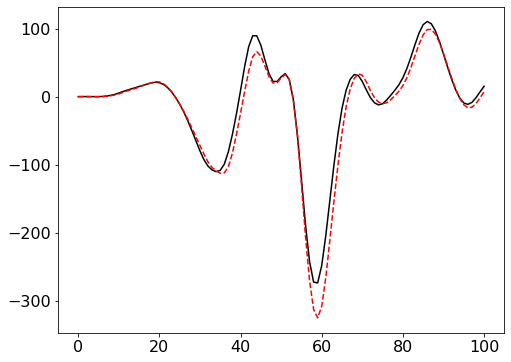

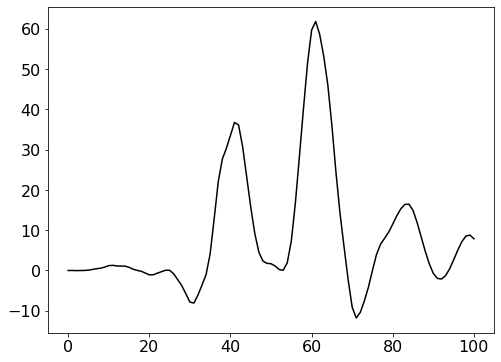

In [15]:
eps = 0
f = lambda x: fun(x, m, b, t, dt, eps)
g = lambda x: grad(x, m, b, t, dt, eps)

x0 = dt * np.arange(nt) / 2
gana = g(x0)
gapprox = approx_fprime(x0, f, 1e-8)
print(check_grad(f, g, x0, epsilon=1e-8))

plt.figure()
plt.plot(gana, 'k')
plt.plot(gapprox, '--r')

plt.figure()
plt.plot(gana - gapprox , 'k');

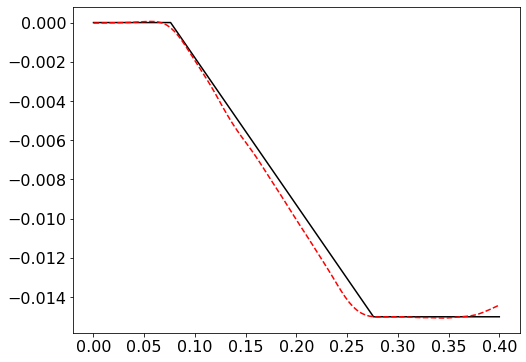

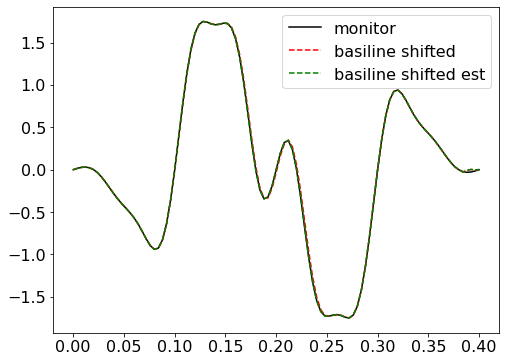

In [16]:
eps = 5e3
f = lambda x: fun(x, m, b, t, dt, eps)
g = lambda x: grad(x, m, b, t, dt, eps)

nlest = minimize(f, np.zeros(nt), jac=g, method='L-BFGS-B', options=dict(maxiter=200))
#nlest = minimize(fun, np.zeros(nt), jac=grad, args=(m, b, t, dt, eps), 
#                 method='L-BFGS-B', options=dict(maxiter=100))
shift_est = nlest.x

# shift back
tshift = t - shift_est
iava = tshift/dt
SI1op, iava = Interp(nt, iava, kind='sinc', dtype='float64')
bshifted_est  = SI1op*b

plt.figure()
plt.plot(t, shift, 'k')
plt.plot(t, shift_est, '--r')

plt.figure()
plt.plot(t, m, 'k', label='monitor')
plt.plot(t, bshifted, '--r', label='basiline shifted')
plt.plot(t, bshifted_est, '--g', label='basiline shifted est')
plt.legend();

# 2D Inversion

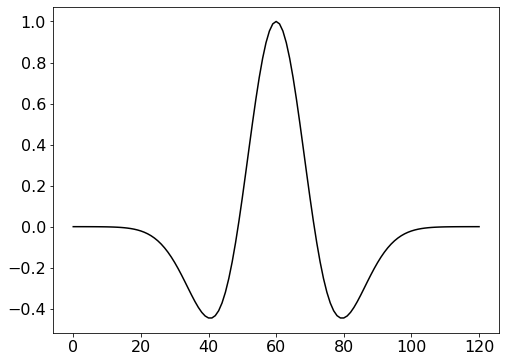

In [17]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'][::5], model['z'], np.log(model['model'][:, ::5])
x = x - x[0]
t = np.arange(len(z)) * 0.004
nx, nt = len(x), len(t)

ntwav = 61
twav = np.arange(ntwav) * 0.004
wav = ricker(twav, 5)[0]

plt.figure()
plt.plot(wav, 'k');

Create monitor data

In [18]:
PPop = PoststackLinearModelling(wav, nt0=nt, spatdims=nx, explicit=False)
m = (PPop*m.flatten()).reshape(nt, nx).T

Apply shift to baseline data

In [19]:
strain = np.zeros((nx, nt))
strain[:100, 200:220] = -4e-4
strain[100:nx, 200:220] = 2e-4
strain = gaussian_filter(strain, 3)
shift = np.cumsum(strain, axis=1)
tshift = t[np.newaxis, :] - (-shift)
iavas = tshift / dt

SI1op = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])

b = SI1op * m.ravel()
b = b.reshape(nx, nt)

Apply opposite shift to monitor to recover baseline



In [20]:
tshift = t[np.newaxis, :] - shift
iavas = tshift / dt

SI1op = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])

bshifted = SI1op * b.ravel()
bshifted = bshifted.reshape(nx, nt)

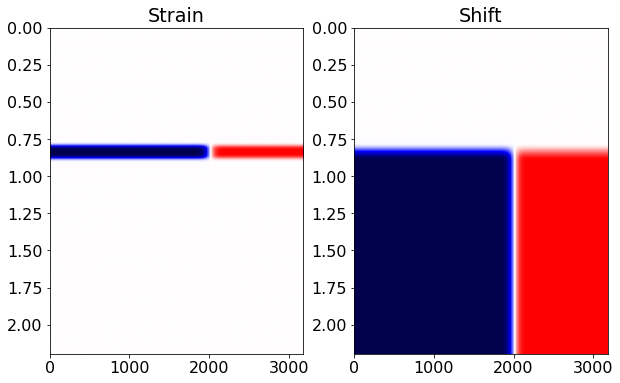

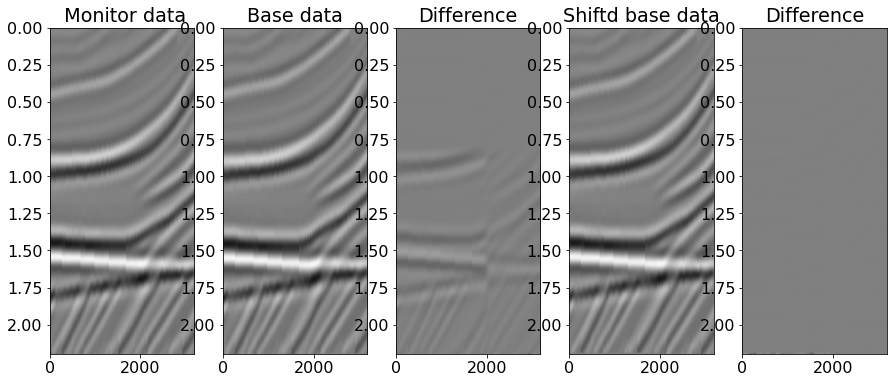

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(strain.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(strain).max(), vmax=np.abs(strain).max())
axs[0].set_title('Strain')
axs[0].axis('tight')
axs[1].imshow(shift.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[1].set_title('Shift')
axs[1].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(15, 6))
axs[0].imshow(m.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[0].set_title(' Monitor data')
axs[0].axis('tight')
axs[1].imshow(b.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[1].set_title('Base data')
axs[1].axis('tight')
axs[2].imshow(m.T - b.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[2].set_title('Difference')
axs[2].axis('tight')
axs[3].imshow(bshifted.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[3].set_title('Shiftd base data')
axs[3].axis('tight')
axs[4].imshow(m.T - bshifted.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[4].set_title('Difference')
axs[4].axis('tight');

### Single iteration

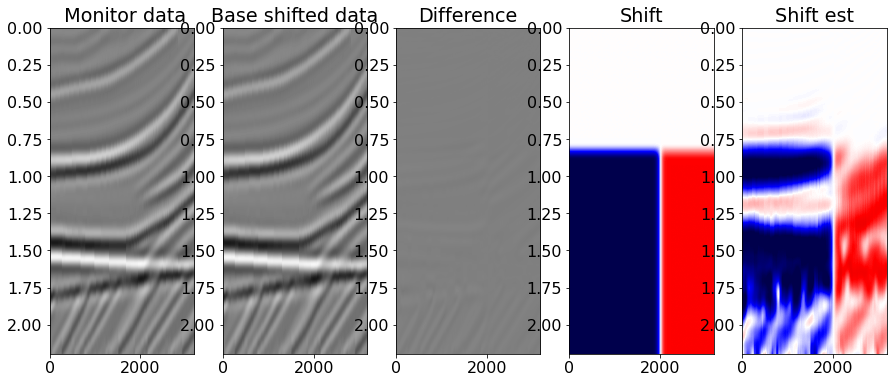

In [23]:
# Data
mbdiff = m[:, 0:-1] - b[:, 0:-1]

# Jabobian
Dm = - Diagonal((b[:, 1:] - b[:, 0:-1]).ravel() / dt)

# Second Derivative regularization
R = SecondDerivative(dims=(nx, nt-1), axis=1)
#R = Laplacian(dims=(nx, nt))


shift_est = regularized_inversion(Dm, mbdiff.ravel(), [R, ], epsRs=[1e3, ], **dict(iter_lim=500))[0]
shift_est = shift_est.reshape(nx, nt-1)

# shift back
tshift = t[np.newaxis, :-1] - shift_est
iavas = tshift / dt
SI1op = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])
bshifted_est = SI1op * b.ravel()
bshifted_est = bshifted_est.reshape(nx, nt-1)

fig, axs = plt.subplots(1, 5, figsize=(15, 6))
axs[0].imshow(m.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[0].set_title(' Monitor data')
axs[0].axis('tight')
axs[1].imshow(bshifted_est.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[1].set_title('Base shifted data')
axs[1].axis('tight')
axs[2].imshow(m[:, :-1].T - bshifted_est.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[2].set_title('Difference')
axs[2].axis('tight')
axs[3].imshow(shift.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[3].set_title('Shift')
axs[3].axis('tight')
axs[4].imshow(shift_est.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[4].set_title('Shift est')
axs[4].axis('tight');

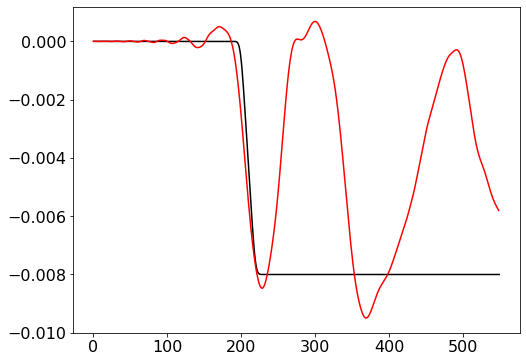

In [26]:
plt.figure()
plt.plot(shift[nx//2], 'k')
plt.plot(shift_est[nx//2], 'r');

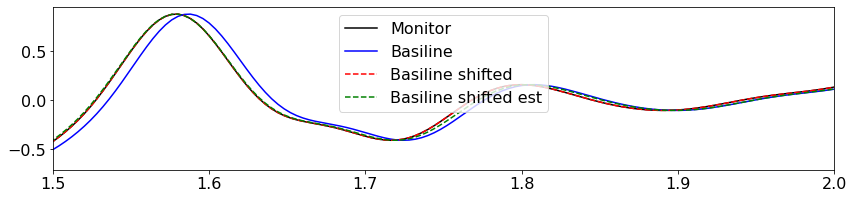

In [28]:
plt.figure(figsize=(14, 3))
plt.plot(t, m[nx//2], 'k', label='Monitor')
plt.plot(t, b[nx//2], 'b', label='Basiline')
plt.plot(t, bshifted[nx//2], '--r', label='Basiline shifted')
plt.plot(t[:-1], bshifted_est[nx//2], '--g', label='Basiline shifted est')
plt.xlim(1.5, 2)
plt.legend();

### Gauss-newton inversion

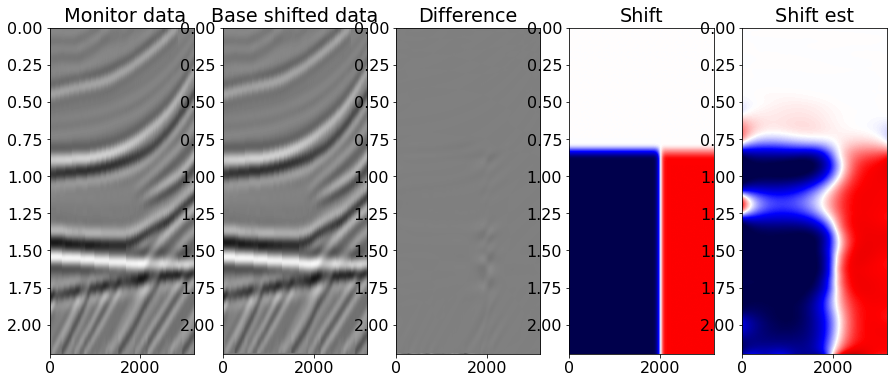

In [29]:
niter = 5

shift_est = np.zeros((nx, nt))
shift_ests = np.zeros((niter, nx, nt))
for iiter in range(niter):
    # Interpolate baseline to current time shift estimate
    iavas = (t[np.newaxis, :] - shift_est)/dt
    SIop = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])
    SI1op = BlockDiag([Interp(nt, i+1, kind='sinc', dtype='float64')[0] for i in iavas])
    
    bshift = SIop * b.ravel()
    b1shift = SI1op * b.ravel()
    
    # Data
    mbdiff = m.ravel() - bshift.ravel()
    
    # Jabobian
    Dm = - Diagonal((b1shift - bshift) / dt)
    
    # Second Derivative regularization
    R = Laplacian(dims=(nx, nt))
    shift_est += regularized_inversion(Dm, mbdiff, [R, ], epsRs=[1e3, ], dataregs=[-R * shift_est.ravel(), ], 
                                      **dict(iter_lim=1000, damp=1e-4))[0].reshape(nx, nt)
    shift_ests[iiter] = shift_est

# shift back
tshift = t[np.newaxis, :] - shift_est
iavas = tshift / dt
SI1op = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])
bshifted_est = SI1op * b.ravel()
bshifted_est = bshifted_est.reshape(nx, nt)

fig, axs = plt.subplots(1, 5, figsize=(15, 6))
axs[0].imshow(m.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[0].set_title(' Monitor data')
axs[0].axis('tight')
axs[1].imshow(bshifted_est.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[1].set_title('Base shifted data')
axs[1].axis('tight')
axs[2].imshow(m.T - bshifted_est.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[2].set_title('Difference')
axs[2].axis('tight')
axs[3].imshow(shift.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[3].set_title('Shift')
axs[3].axis('tight')
axs[4].imshow(shift_est.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[4].set_title('Shift est')
axs[4].axis('tight');

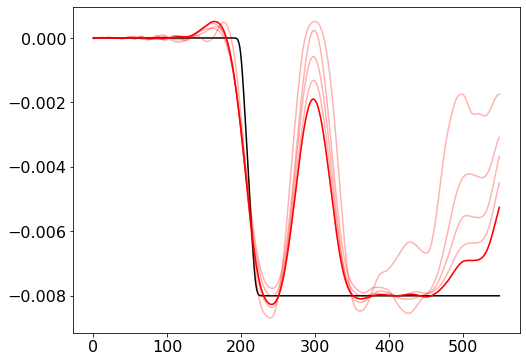

In [30]:
plt.figure()
plt.plot(shift[20], 'k')
plt.plot(shift_est[20], 'r')
plt.plot(shift_ests[:, 20].T, 'r', alpha=0.3);

### Quasi-newton inversion

In [31]:
def fun(x, m, b, t, dt, eps):
    nx, nt = m.shape
    x = x.reshape(nx, nt)
    iavas = (t[np.newaxis, :] - x)/dt
    SIop = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])
    #Rop = SecondDerivative(nt*nx, dims=(nx, nt), dir=1)
    Rop = Laplacian(dims=(nx, nt))
    bshift = SIop * b.ravel()
    res = m.ravel() - bshift
    return np.linalg.norm(res) ** 2 + eps*np.linalg.norm(Rop * x.ravel()) ** 2

def grad(x, m, b, t, dt, eps):
    nx, nt = m.shape
    x = x.reshape(nx, nt)
    iavas = (t[np.newaxis, :] - x)/dt
    SIop = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])
    SI1op = BlockDiag([Interp(nt, i+1, kind='sinc', dtype='float64')[0] for i in iavas])
    J = Diagonal((SI1op * b.ravel() - SIop * b.ravel()) / dt)
    #Rop = SecondDerivative(nt*nx, dims=(nx, nt), dir=1)
    Rop = Laplacian(dims=(nx, nt))
    bshift = SIop * b.ravel()
    res = m.ravel() - bshift
    grad = 2*J.H*res + 2*eps*Rop.H*Rop*x.ravel()
    return grad

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        88000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.14231D+02    |proj g|=  1.26582D+01

At iterate    2    f=  1.32324D+02    |proj g|=  9.29719D+01

At iterate    4    f=  6.02425D+01    |proj g|=  3.90517D+01

At iterate    6    f=  5.70260D+01    |proj g|=  2.61761D+01

At iterate    8    f=  4.41939D+01    |proj g|=  9.42414D+01

At iterate   10    f=  3.63129D+01    |proj g|=  1.91791D+01

At iterate   12    f=  3.28324D+01    |proj g|=  2.05485D+01

At iterate   14    f=  2.92373D+01    |proj g|=  1.49854D+01

At iterate   16    f=  2.74576D+01    |proj g|=  1.48050D+01

At iterate   18    f=  2.53769D+01    |proj g|=  1.72890D+01

At iterate   20    f=  2.36075D+01    |proj g|=  1.20807D+01

At iterate   22    f=  2.14526D+01    |proj g|=  1.84752D+01

At iterate   24    f=  1.92497D+01    |proj g|=  7.27516D+00

At iterate   26    f=  1.7

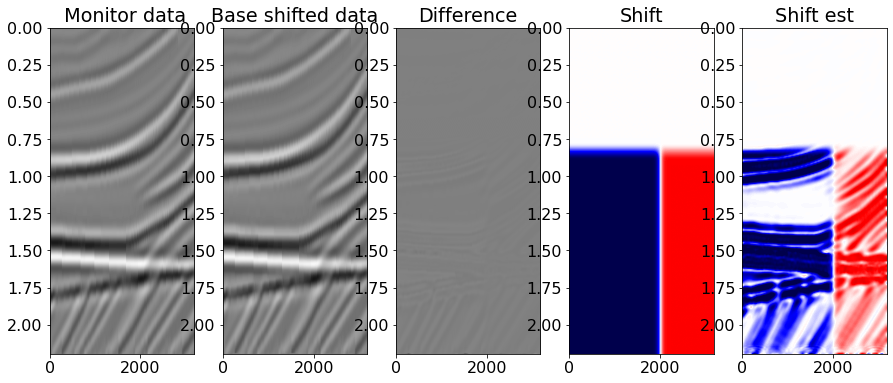

In [32]:
eps = 1e3
nlest = minimize(fun, np.zeros(nt*nx), jac=grad, args=(m, b, t, dt, eps), 
                 method='L-BFGS-B', options=dict(maxiter=30, disp=2))
shift_est = nlest.x.reshape(nx, nt)

# shift back
tshift = t[np.newaxis, :] - shift_est
iavas = tshift / dt
SI1op = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])
bshifted_est = SI1op * b.ravel()
bshifted_est = bshifted_est.reshape(nx, nt)

fig, axs = plt.subplots(1, 5, figsize=(15, 6))
axs[0].imshow(m.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[0].set_title(' Monitor data')
axs[0].axis('tight')
axs[1].imshow(bshifted_est.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[1].set_title('Base shifted data')
axs[1].axis('tight')
axs[2].imshow(m.T - bshifted_est.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-1, vmax=1)
axs[2].set_title('Difference')
axs[2].axis('tight')
axs[3].imshow(shift.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[3].set_title('Shift')
axs[3].axis('tight')
axs[4].imshow(shift_est.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[4].set_title('Shift est')
axs[4].axis('tight');

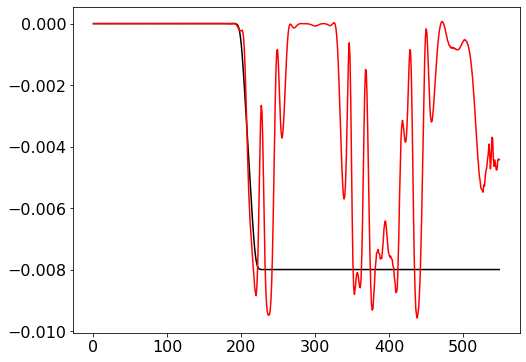

In [33]:
plt.figure()
plt.plot(shift[nx//2], 'k')
plt.plot(shift_est[nx//2], 'r')

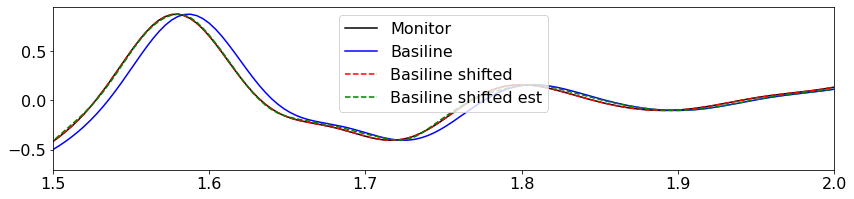

In [34]:
plt.figure(figsize=(14, 3))
plt.plot(t, m[nx//2], 'k', label='Monitor')
plt.plot(t, b[nx//2], 'b', label='Basiline')
plt.plot(t, bshifted[nx//2], '--r', label='Basiline shifted')
plt.plot(t, bshifted_est[nx//2], '--g', label='Basiline shifted est')
plt.xlim(1.5, 2)
plt.legend();

# 2D Real data

In [ ]:
segyfile = '/Users/matteoravasi/Desktop/Statoil/2019/Projects/PyLops_docker/pylops_docker_private/data/ST10010ZC11_PZ_PSDM_KIRCH_FAR_D.MIG_FIN.POST_STACK.3D.JS-017536.segy'
itmin = 600 # index of first time/depth sample in data used in colored inversion
itmax = 800 # number of samples of statistical wavelet

f = segyio.open(segyfile, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
traces = traces[:, itmin:itmax]
ntraces, nt = traces.shape

t = f.samples[itmin:itmax]
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

nil, nxl, nt = len(ilines), len(xlines), len(t)

# Display data
plt.figure(figsize=(12, 6))
plt.imshow(d[nil//2].T, cmap='gray', vmin=-5, vmax=5,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Seismic data - section')
plt.colorbar()
plt.axis('tight')

In [ ]:
m = d[nil//2, ::3]
nx, nt = m.shape
dt = 0.004
t = np.arange(nt) * 0.004

strain = np.zeros((nx, nt))
strain[:100, 100:120] = -4e-4
strain[100:nx, 100:120] = 2e-4
strain = gaussian_filter(strain, 3)
shift = np.cumsum(strain, axis=1)

# apply shift
tshift = t[np.newaxis, :] - (-shift)
iavas = tshift / dt

SI1op = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])

b = SI1op * m.ravel()
b = b.reshape(nx, nt)

# apply opposite shift
tshift = t[np.newaxis, :] - shift
iavas = tshift / dt

SI1op = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])

bshifted = SI1op * b.ravel()
bshifted = bshifted.reshape(nx, nt)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(strain.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(strain).max(), vmax=np.abs(strain).max())
axs[0].set_title('Strain')
axs[0].axis('tight')
axs[1].imshow(shift.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[1].set_title('Shift')
axs[1].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].imshow(m.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-5, vmax=5)
axs[0].set_title(' Monitor data')
axs[0].axis('tight')
axs[1].imshow(b.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-5, vmax=5)
axs[1].set_title('Base data')
axs[1].axis('tight')
axs[2].imshow(m.T - b.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-5, vmax=5)
axs[2].set_title('Difference')
axs[2].axis('tight')
axs[3].imshow(bshifted.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-5, vmax=5)
axs[3].set_title('Shiftd base data')
axs[3].axis('tight')
axs[4].imshow(m.T - bshifted.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-5, vmax=5)
axs[4].set_title('Difference')
axs[4].axis('tight');

### Single iteration

In [ ]:
# Data
mbdiff = m[:, 0:-1] - b[:, 0:-1]

# Jabobian
Dm = - Diagonal((b[:, 1:] - b[:, 0:-1]).ravel() / dt)

# Second Derivative regularization
R = SecondDerivative((nt-1)*nx, dims=(nx, nt-1), dir=1)

shift_est = RegularizedInversion(Dm, [R, ], mbdiff.ravel(), epsRs=[1e3, ], **dict(iter_lim=1000))
shift_est = shift_est.reshape(nx, nt-1)

# shift back
tshift = t[np.newaxis, :-1] - shift_est
iavas = tshift / dt
SI1op = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])
bshifted_est = SI1op * b.ravel()
bshifted_est = bshifted_est.reshape(nx, nt-1)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].imshow(m.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-5, vmax=5)
axs[0].set_title(' Monitor data')
axs[0].axis('tight')
axs[1].imshow(bshifted_est.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-5, vmax=5)
axs[1].set_title('Base shifted data')
axs[1].axis('tight')
axs[2].imshow(m[:, :-1].T - bshifted_est.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-2, vmax=2)
axs[2].set_title('Difference')
axs[2].axis('tight')
axs[3].imshow(shift.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[3].set_title('Shift')
axs[3].axis('tight')
axs[4].imshow(shift_est.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[4].set_title('Shift est')
axs[4].axis('tight');

In [ ]:
plt.figure()
plt.plot(shift[nx//2], 'k')
plt.plot(shift_est[nx//2], 'r')

In [ ]:
plt.figure(figsize=(14, 3))
plt.plot(t, m[nx//2], 'k', label='Monitor')
plt.plot(t, b[nx//2], 'b', label='Basiline')
plt.plot(t, bshifted[nx//2], '--r', label='Basiline shifted')
plt.plot(t[:-1], bshifted_est[nx//2], '--g', label='Basiline shifted est')
plt.legend();

In [ ]:
eps = 1e4
nlest = minimize(fun, np.zeros(nt*nx), jac=grad, args=(m, b, t, dt, eps), 
                 method='L-BFGS-B', options=dict(maxiter=20, iprint=100))
shift_est = nlest.x.reshape(nx, nt)

# shift back
tshift = t[np.newaxis, :] - shift_est
iavas = tshift / dt
SI1op = BlockDiag([Interp(nt, i, kind='sinc', dtype='float64')[0] for i in iavas])
bshifted_est = SI1op * b.ravel()
bshifted_est = bshifted_est.reshape(nx, nt)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].imshow(m.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-5, vmax=5)
axs[0].set_title(' Monitor data')
axs[0].axis('tight')
axs[1].imshow(bshifted_est.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-5, vmax=5)
axs[1].set_title('Base shifted data')
axs[1].axis('tight')
axs[2].imshow(m.T - bshifted_est.T, cmap='gray', extent = (x[0], x[-1], t[-1], t[0]), vmin=-5, vmax=5)
axs[2].set_title('Difference')
axs[2].axis('tight')
axs[3].imshow(shift.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[3].set_title('Shift')
axs[3].axis('tight')
axs[4].imshow(shift_est.T, cmap='seismic', extent = (x[0], x[-1], t[-1], t[0]),
              vmin=-np.abs(shift).max(), vmax=np.abs(shift).max())
axs[4].set_title('Shift est')
axs[4].axis('tight');

In [ ]:
plt.figure()
plt.plot(shift[nx//2], 'k')
plt.plot(shift_est[nx//2], 'r')

In [ ]:
plt.figure(figsize=(14, 3))
plt.plot(t, m[nx//2], 'k', label='Monitor')
plt.plot(t, b[nx//2], 'b', label='Basiline')
plt.plot(t, bshifted[nx//2], '--r', label='Basiline shifted')
plt.plot(t, bshifted_est[nx//2], '--g', label='Basiline shifted est')
plt.legend();